<a href="https://colab.research.google.com/github/TaekGwonNam/2024.VAI/blob/main/%5B%EC%8B%A4%EC%8A%B503%5D_%EC%8B%AC%EC%B8%B5%EC%8B%A0%EA%B2%BD%EB%A7%9D_%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

batch_size=16
learning_rate=0.002
num_epoch=1

In [2]:
cifar_train=dset.CIFAR10("CIFAR10/", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test=dset.CIFAR10("CIFAR10/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

100%|██████████| 170498071/170498071 [00:11<00:00, 15336021.58it/s]


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/
Files already downloaded and verified


cifar_train 길이:  50000
cifar_test 길이:  10000
image data 형태:  torch.Size([3, 32, 32])
label:  9


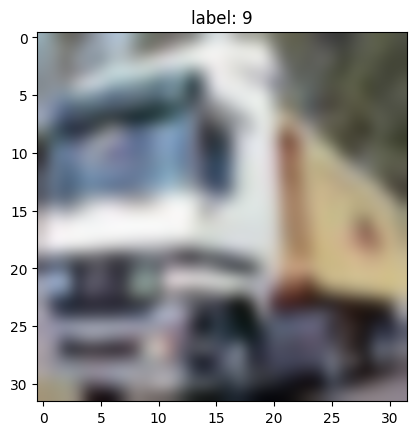

In [3]:
print ("cifar_train 길이: ", len(cifar_train))
print ("cifar_test 길이: ", len(cifar_test))

image, label = cifar_train.__getitem__(1)
print("image data 형태: ", image.size())
print("label: ", label)

img = image.numpy()

r,g,b = img[0,:,:], img[1,:,:], img[2,:,:]

img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r,g,b

plt.title("label: %d" %label)
plt.imshow(img2,interpolation='bicubic')
plt.show()

In [4]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0

  for j, [imgs, labels] in enumerate(dloader):
    img = Variable(imgs,volatile=True).cuda()
    label = Variable(labels).cuda()

    output = imodel.forward(img)
    _, output_index = torch.max(output, 1)

    total += label.size(0)
    correct += (output_index == label).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))

In [8]:
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

#=============모델선언======
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.layer=nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),

        nn.Conv2d(16,32,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        nn.Linear(100,10)
    )

  def forward(self,x):
    out=self.layer(x)
    out=out.view(batch_size,-1)
    out=self.fc_layer(out)

    return out

model=CNN().cuda()

In [9]:
#==loss, optimizer==
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

#==학습==
for i in range(num_epoch):
  for j,[image, label] in enumerate(train_loader):
    x=Variable(image).cuda()
    y_=Variable(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j%1000==0:
      print(j, loss)

0 tensor(2.3182, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(2.2954, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(2.2882, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(2.2530, device='cuda:0', grad_fn=<NllLossBackward0>)


In [11]:
ComputeAccr(test_loader, model)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-4-52fe969dc990>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(imgs,volatile=True).cuda()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of Test Data: 19.899999618530273


In [12]:
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

#=============모델선언(드롭아웃)======
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.layer=nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
        nn.Dropout2d(0,2),

        nn.Conv2d(16,32,3,padding=1),
        nn.ReLU(),
        nn.Dropout2d(0,2),

        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        nn.Dropout2d(0,2),

        nn.MaxPool2d(2,2)
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        nn.Dropout2d(0,2),

        nn.Linear(100,10)
    )

  def forward(self,x):
    out=self.layer(x)
    out=out.view(batch_size,-1)
    out=self.fc_layer(out)

    return out

model=CNN().cuda()

In [13]:
ComputeAccr(test_loader, model)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-4-52fe969dc990>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(imgs,volatile=True).cuda()
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with 

Accuracy of Test Data: 10.0


In [14]:
#=============모델선언(원복)======
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.layer=nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
       # nn.Dropout2d(0,2),

        nn.Conv2d(16,32,3,padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0,2),

        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0,2),

        nn.MaxPool2d(2,2)
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        #nn.Dropout2d(0,2),

        nn.Linear(100,10)
    )

  def forward(self,x):
    out=self.layer(x)
    out=out.view(batch_size,-1)
    out=self.fc_layer(out)

    return out

model=CNN().cuda()

In [16]:
cifar_train=dset.CIFAR10("CIFAR10/", train=True, transform=transforms.Compose([
    transforms.Resize(36),
    transforms.CenterCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(lambda x: x.rotate(90)),
    transforms.ToTensor()
]))
cifar_test=dset.CIFAR10("CIFAR10/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

Files already downloaded and verified


In [17]:
ComputeAccr(test_loader, model)
#12페이지

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-4-52fe969dc990>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(imgs,volatile=True).cuda()


Accuracy of Test Data: 10.0


In [18]:
#=============모델선언(원복)======
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.layer=nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
       # nn.Dropout2d(0,2),

        nn.Conv2d(16,32,3,padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0,2),

        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0,2),

        nn.MaxPool2d(2,2)
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        #nn.Dropout2d(0,2),

        nn.Linear(100,10)
    )

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)
      if isinstance(m, nn.Linear):
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)

  def forward(self,x):
    out=self.layer(x)
    out=out.view(batch_size,-1)
    out=self.fc_layer(out)

    return out

model=CNN().cuda()

<ipython-input-18-32ed949d0cf4>:31: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)
<ipython-input-18-32ed949d0cf4>:34: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)


In [19]:
ComputeAccr(test_loader, model)
#13페이지

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-4-52fe969dc990>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(imgs,volatile=True).cuda()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of Test Data: 11.039999961853027


In [20]:
cifar_train=dset.CIFAR10("CIFAR10/", train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
])
,target_transform=None, download=False)

cifar_test=dset.CIFAR10("CIFAR10/", train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
])
,target_transform=None, download=False)

In [21]:
ComputeAccr(test_loader, model)
#14페이지

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-4-52fe969dc990>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(imgs,volatile=True).cuda()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of Test Data: 11.039999961853027


In [24]:
#=============모델선언(15)======
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.layer=nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
       # nn.Dropout2d(0,2),
        nn.BatchNorm2d(16),

        nn.Conv2d(16,32,3,padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0,2),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0,2),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        #nn.Dropout2d(0,2),
        nn.BatchNorm1d(100),

        nn.Linear(100,10)
    )

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)
      if isinstance(m, nn.Linear):
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)

  def forward(self,x):
    out=self.layer(x)
    out=out.view(batch_size,-1)
    out=self.fc_layer(out)

    return out

model=CNN().cuda()

<ipython-input-24-db2c657c953e>:33: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)
<ipython-input-24-db2c657c953e>:36: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)


In [25]:
ComputeAccr(test_loader, model)
#15페이지

<ipython-input-4-52fe969dc990>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(imgs,volatile=True).cuda()


Accuracy of Test Data: 9.239999771118164


In [26]:
#==loss, optimizer==
loss_func=nn.CrossEntropyLoss()
#optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

#==학습==
for i in range(num_epoch):
  for j,[image, label] in enumerate(train_loader):
    x=Variable(image).cuda()
    y_=Variable(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j%1000==0:
      print(j, loss)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0 tensor(3.1004, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.2457, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(1.0862, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(0.6182, device='cuda:0', grad_fn=<NllLossBackward0>)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [27]:
ComputeAccr(test_loader, model)
#16페이지

<ipython-input-4-52fe969dc990>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(imgs,volatile=True).cuda()


Accuracy of Test Data: 62.09000015258789


In [28]:
num_epoch=60

In [29]:
#==loss, optimizer==
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)

#==학습==
for i in range(num_epoch):
  for j,[image, label] in enumerate(train_loader):
    x=Variable(image).cuda()
    y_=Variable(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j%1000==0:
      print(j, loss)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0 tensor(0.7210, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(0.8481, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(0.9405, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(0.8995, device='cuda:0', grad_fn=<NllLossBackward0>)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0 tensor(0.8643, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(0.9391, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(0.6089, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(0.7486, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.4985, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(0.4622, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(0.7190, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(0.7253, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.3432, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(0.7428, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(0.6989, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(0.6032, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.6668, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(0.6751, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(0.6495, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(0.9751, device='cuda:0', 

In [30]:
ComputeAccr(test_loader, model)
#17페이지

<ipython-input-4-52fe969dc990>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(imgs,volatile=True).cuda()


Accuracy of Test Data: 69.58000183105469


In [32]:
netname='./nets/mlp_weight.pkl'
torch.save(model, netname,)

model = torch.load(netname)

ComputeAccr(test_loader,model)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-4-52fe969dc990>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(imgs,volatile=True).cuda()


Accuracy of Test Data: 69.58000183105469
